# Описание данных 

Данные клиента за предыдущий до проверки факта оттока месяц:
- `gender` — пол;
- `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
- `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- `Phone` — наличие контактного телефона;
- `Age` — возраст;
- `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
- `Group_visits` — факт посещения групповых занятий;
- `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
- `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
- `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- `Churn` — факт оттока в текущем месяце.

# План работы
- Изучить файлы с данными.
- Проверить данные на пропуски, дубликаты.
- Провести исследовательский анализ
- Визуализировать данные.
- Проверить корреляцию
- Подготовить данные к обучению(разбить данные на выборки: обучающую, тестовую).
- Обучить разные модели.
- Проанализировать скорость работы и качество моделей.
- Провести кластеризацию.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from scipy.cluster.hierarchy import dendrogram, linkage 

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score
from sklearn.metrics import silhouette_score


import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
data.columns = data.columns.str.lower()

In [5]:
def check(data):
    data.info()
    nan_perc = data.isna().sum() / data.shape[0] * 100
    print()
    print('Индекс упорядочен:',data.index.is_monotonic)
    print('Кол-во дубликатов -',data.duplicated().sum())
    print()
    print('\033[1mКол-во пропусков:\033[0m')
    print(data.isna().sum())
    print()
    print('\033[1mПроцент пропусков:\033[0m')
    print(nan_perc.sort_values(ascending=False))
    print('---------------------------')
    for column in data.columns:
        print()
        print('\033[1mCтолбец\033[0m', column)
        print('Кол-во уникальных значений -',data[column].nunique())
        print('Кол-во пропусков -',data[column].isnull().sum())
        print('Кол-во дубликатов -', data[column].duplicated().sum())
        print()
        print(data[column].value_counts().head())
        print()

In [6]:
sns.set(palette='mako', context='talk',style='darkgrid')
def charts(data, column, title):
    fig, axs = plt.subplots(ncols=2,figsize=(20,5))
    plt.suptitle(title, fontsize = "xx-large")
    distplot = sns.distplot(data[column],ax=axs[0])
    sns.boxplot(data[column], ax=axs[1])

In [7]:
def bar(data, column, title):
    plt.suptitle(title, fontsize = "xx-large")
    data[column].value_counts().plot(kind='bar',grid=True,figsize=(10,5))

In [8]:
def histogram(column, title):
    plt.figure(figsize=(12,5))
    plt.title(title, fontsize=15)
    plt.xlabel(['column'],fontsize='10')
    plt.ylabel("Частотность",fontsize='10')
    sns.distplot(left[column], label='Left', kde=False)
    sns.distplot(stay[column], label='Stay', kde=False)
    plt.axvline(np.median(left[column]),color='black', linestyle=':', label='Left медиана')
    plt.axvline(np.median(stay[column]),color='black', linestyle='-', label='Stay медиана')
    plt.legend()

In [9]:
check(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

**Промежуточные выводы:** Пропуски и дубликаты отсутствуют.
Виден явный дисбаланс в данных.
Тип данных в нужном формате.
Данные готовы для дальнейшего анализа.

## Исследовательский анализ данных

In [10]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


**Промежуточные выводы:** 
- Возраст посетителей от 18 до 41. Средний возраст 29 лет. Большинство живет или работает рядом (около 85%). Примерно, половина клиентов являются сотрудниками партнерской программы.
- В среднем длительность абонемента у клиентов — 4.6 месяцев.
- Средняя частота посещений за последний месяц — 1.7 раз в неделю.
- Средняя частота посещений за все время - 1.87 раз в неделю.
- Cредний LTV - 3.7 месяца.
- Доля оттока, примерно, составляет  — 27%

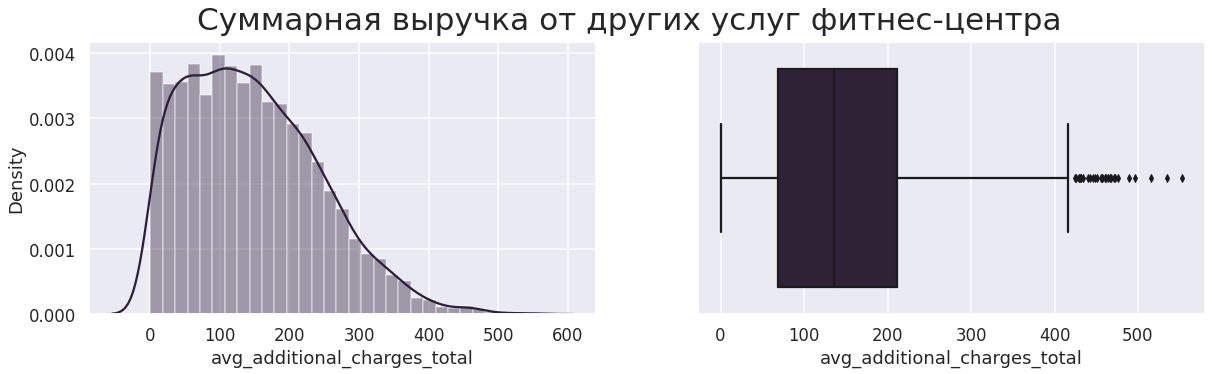

In [11]:
charts(data, 'avg_additional_charges_total','Cуммарная выручка от других услуг фитнес-центра')

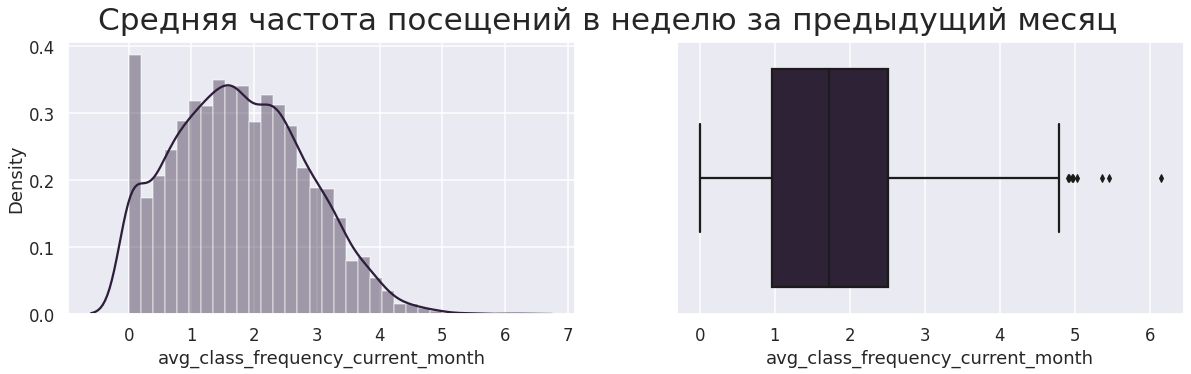

In [12]:
charts(data, 'avg_class_frequency_current_month', 'Cредняя частота посещений в неделю за предыдущий месяц')

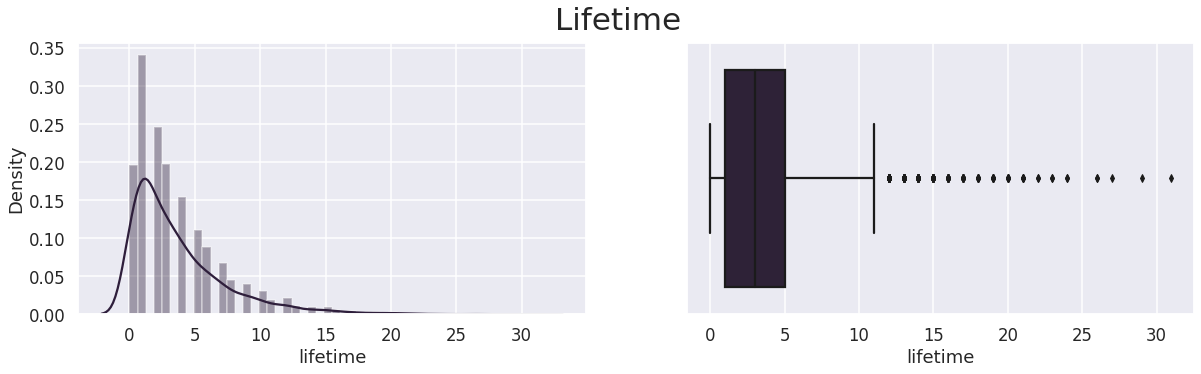

In [13]:
charts(data, 'lifetime', 'Lifetime')

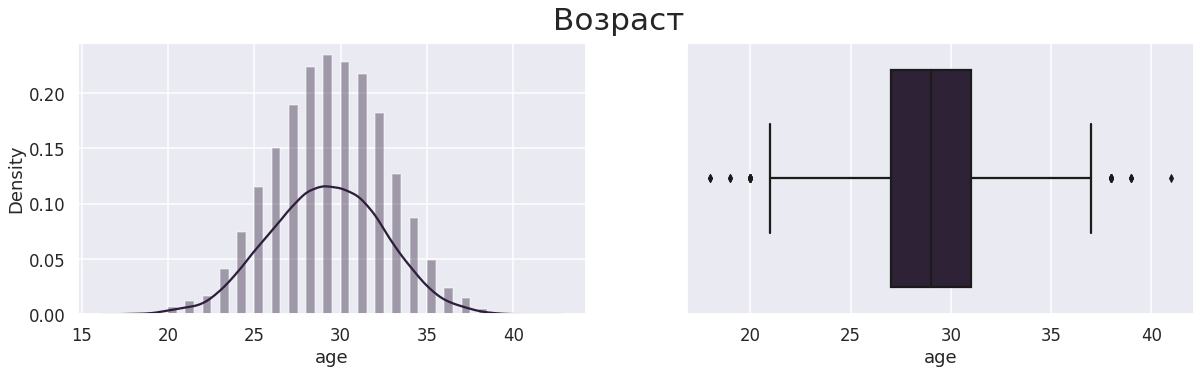

In [14]:
charts(data, 'age', 'Возраст')

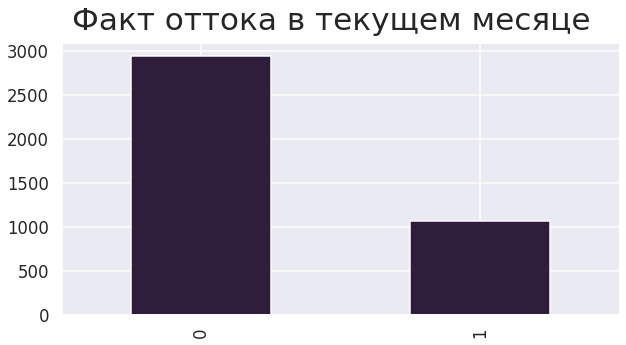

In [15]:
bar(data, 'churn', 'Факт оттока в текущем месяце')

**Промежуточные выводы:**

Визуализировали данные для наглядности. Видим, явный дисбаланс в данных и некоторых случаях незначительные выбросы.

### Анализ посетителей

In [16]:
data.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


In [17]:
stay = data[data['churn'] == 0]
left = data[data['churn'] == 1]

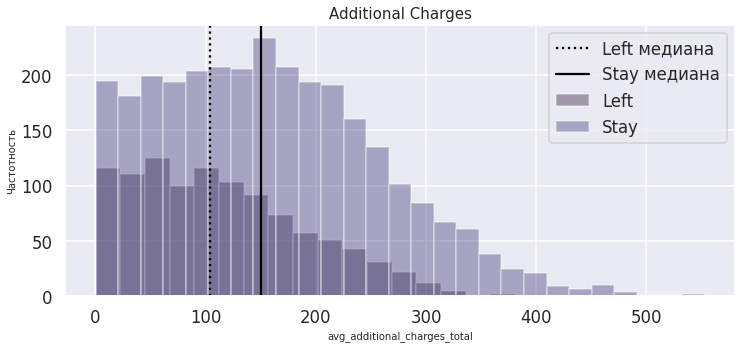

In [18]:
histogram('avg_additional_charges_total', 'Additional Charges')

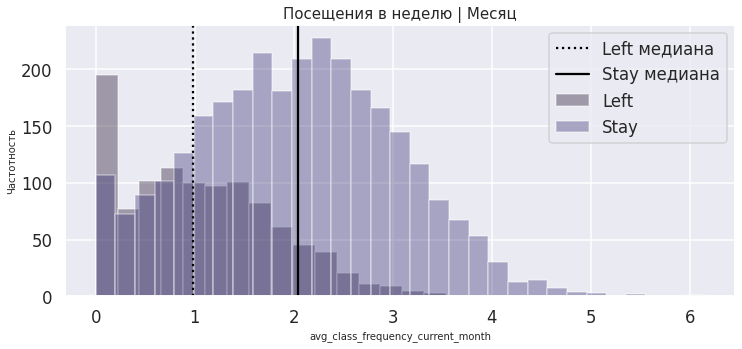

In [19]:
histogram('avg_class_frequency_current_month', 'Посещения в неделю | Месяц')

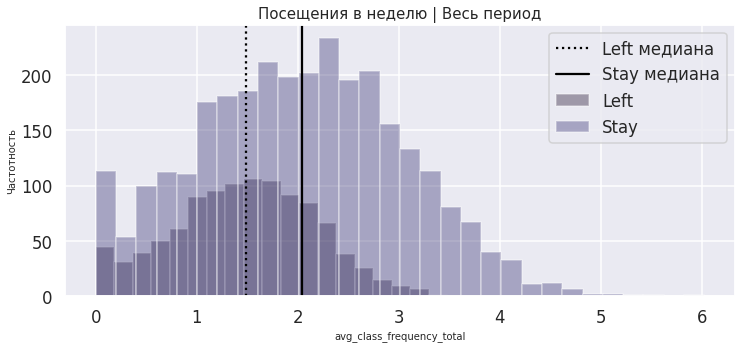

In [20]:
histogram('avg_class_frequency_total', 'Посещения в неделю | Весь период')

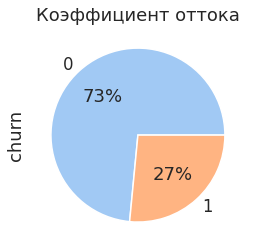

In [21]:
colors = sns.color_palette('pastel')[0:5]
data['churn'].value_counts().plot(kind="pie", colors=colors, autopct="%.0f%%")
plt.title('Коэффициент оттока')
plt.show()

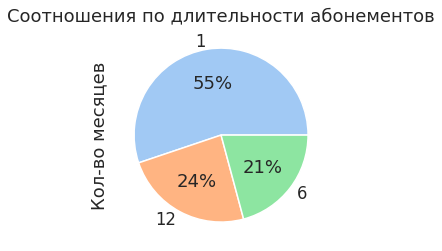

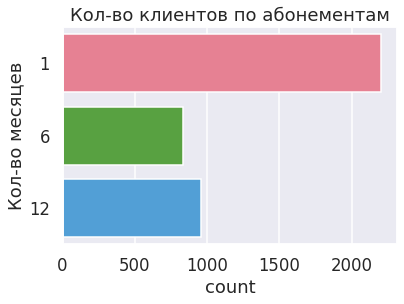

In [22]:
data['contract_period'].value_counts().plot(kind="pie", colors=colors, autopct="%.0F%%")
plt.title('Соотношения по длительности абонементов')
plt.ylabel('Кол-во месяцев')
plt.show()
sns.countplot(y='contract_period', data=data, palette="husl")
plt.title('Кол-во клиентов по абонементам')
plt.ylabel('Кол-во месяцев')
plt.show()

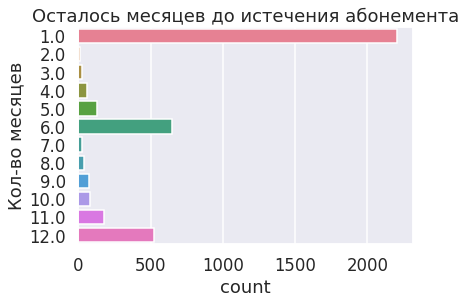

In [23]:
sns.countplot(y='month_to_end_contract', data=data, palette="husl")
plt.title('Осталось месяцев до истечения абонемента')
plt.ylabel('Кол-во месяцев')
plt.show()

**Промежучтоные выводы:** 
- Распределение по полу примерно равное.
- 76% из тех кто ушел, жили или работали рядом с фитнес-центром. Среди ушедших только 35% были сотрудниками  компании-партнёра клуба. А вот те кто остались этот показатель составляет - 53%.
- Клиенты, которые остались более активно используют приглашения друзей (35%) и также посещают групповые занятия (46%), в отличии от тех, что ушли (18% приглашений и 26% посещений).
- Средний возраст оставшихся чуть больше (29 лет),чем тех что ушли (26 лет).
- Также, оставшиеся больше тратить на доп. услуги (в среднем на 40 у.е. больше).
- Заметно, что ушедшие клиенты имеют короткие абонементы на 1-2 месяцев. В то время как, оставшиеся 5-6 месяцев. Также, это видно, по средним значениям month_to_end_contract (срок до окончания текущего действующего абонемента (в месяцах)) Для ушедших оно составляет 1.6, а для оставшихся 5.2.
- LTV соотнесено тоже гораздо выше у оставшихся — 4.7, а у ушедших — 0.9.
- Возможно, клиенты оставшиеся более замотивированны и довольны залом, так как в среднем ходят 2 раза в неделю, а ушедшие всего один.
- На графиках, видно, что больше половины контрактов подходят к концу.
- Далее, визаулизируем по отдельности клиентов ушедших и оставшихся.

### Stayted

In [24]:
print('Кол-во оставшихся клиентов:', stay.shape[0])

Кол-во оставшихся клиентов: 2939


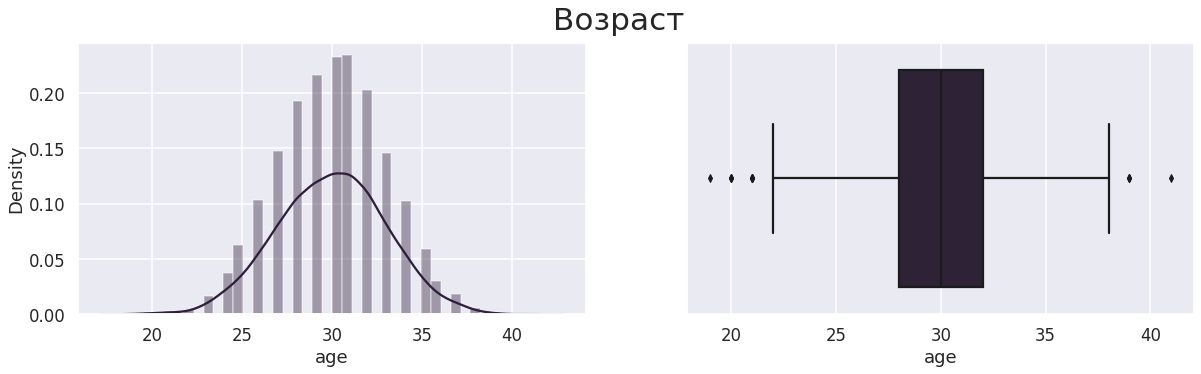

In [25]:
charts(stay, 'age', 'Возраст')

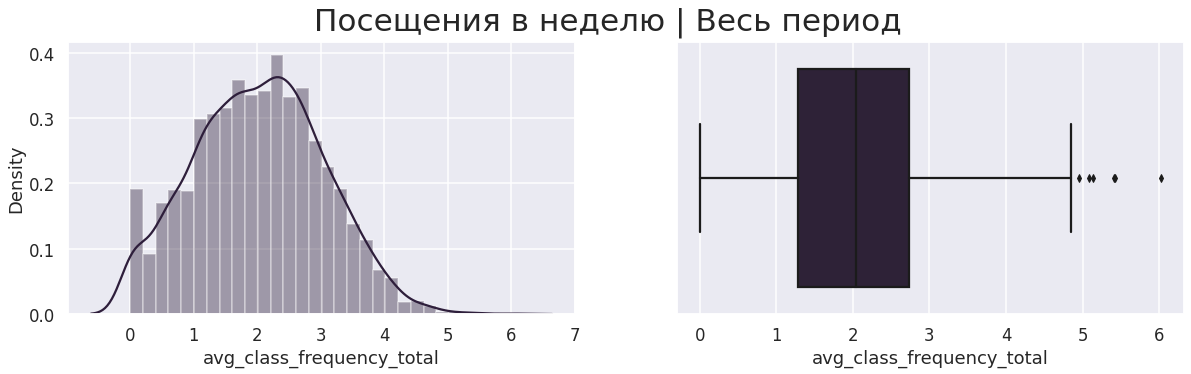

In [26]:
charts(stay, 'avg_class_frequency_total', 'Посещения в неделю | Весь период')

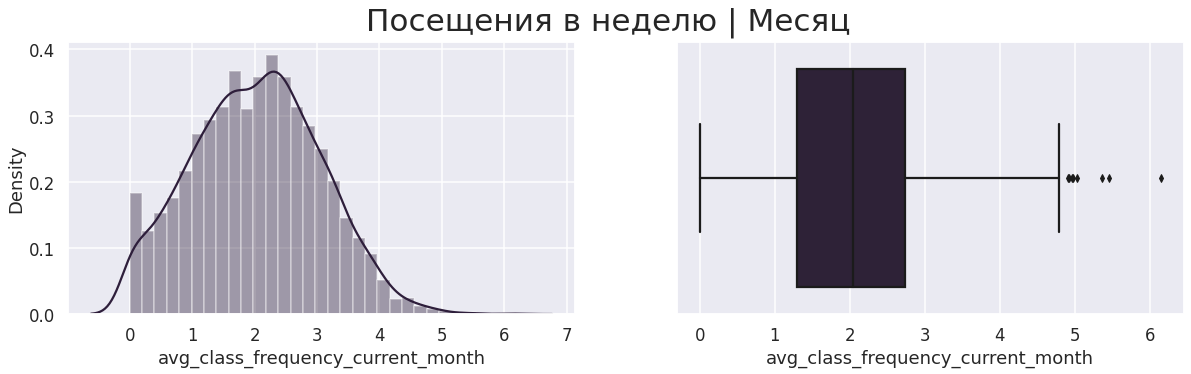

In [27]:
charts(stay, 'avg_class_frequency_current_month', 'Посещения в неделю | Месяц')

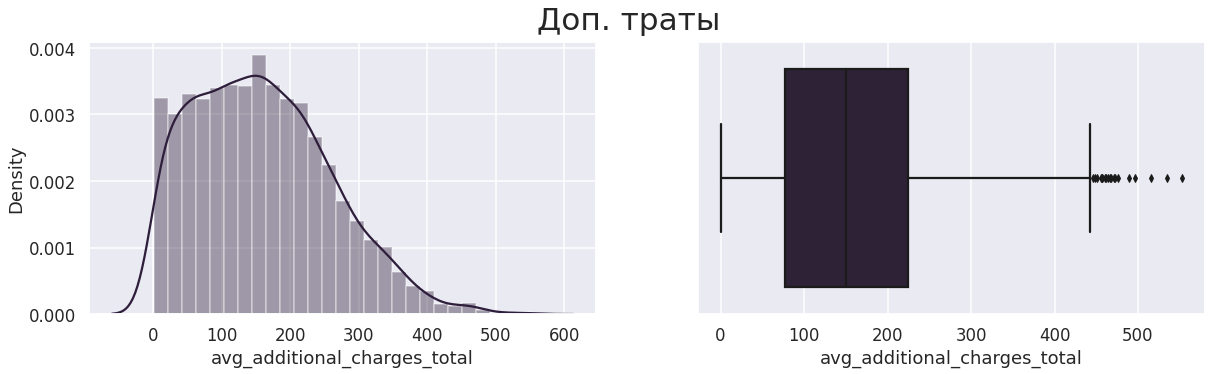

In [28]:
charts(stay, 'avg_additional_charges_total', 'Доп. траты')

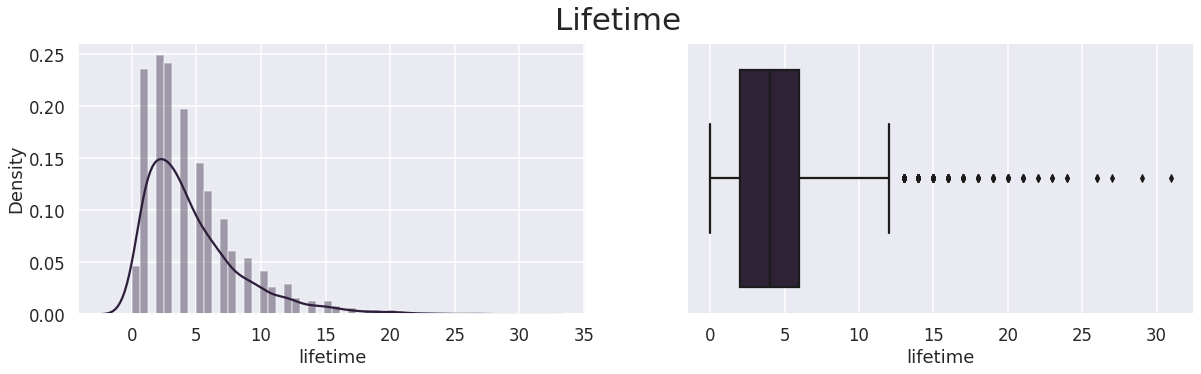

In [29]:
charts(stay, 'lifetime', 'Lifetime')

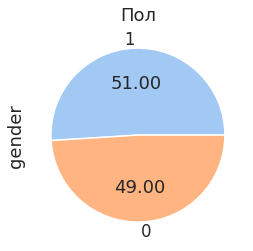

In [30]:
stay['gender'].value_counts().plot(kind="pie", colors=colors, autopct="%.2F")
plt.title('Пол')
plt.show()

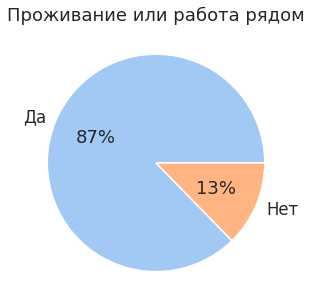

In [31]:
labels = ['Да', 'Нет']
values = stay['near_location'].value_counts()

# pie chart
plt.figure(figsize=(10,5))
plt.title('Проживание или работа рядом')
plt.pie(values, labels=labels, colors=colors, autopct='%.0f%%')
plt.show()

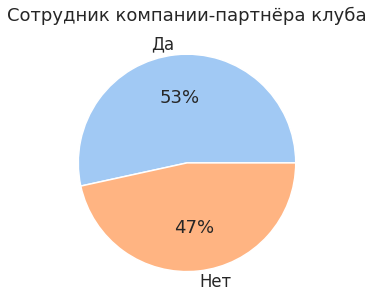

In [32]:
labels = ['Да', 'Нет']
values = stay['partner'].value_counts()

# pie chart
plt.figure(figsize=(10,5))
plt.title('Сотрудник компании-партнёра клуба')
plt.pie(values, labels=labels, colors=colors, autopct='%.0f%%')
plt.show()

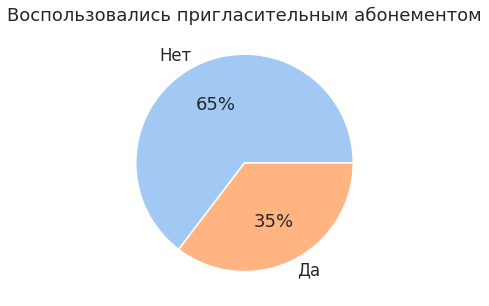

In [33]:
labels = ['Нет', 'Да']
values = stay['promo_friends'].value_counts()

# pie chart
plt.figure(figsize=(10,5))
plt.title('Воспользовались пригласительным абонементом')
plt.pie(values, labels=labels, colors=colors, autopct='%.0f%%')
plt.show()

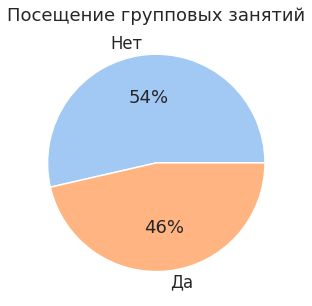

In [34]:
labels = ['Нет', 'Да']
values = stay['group_visits'].value_counts()

# pie chart
plt.figure(figsize=(10,5))
plt.title('Посещение групповых занятий')
plt.pie(values, labels=labels, colors=colors, autopct='%.0f%%')
plt.show()

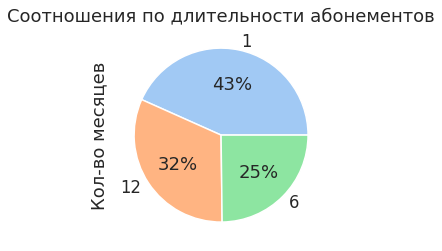

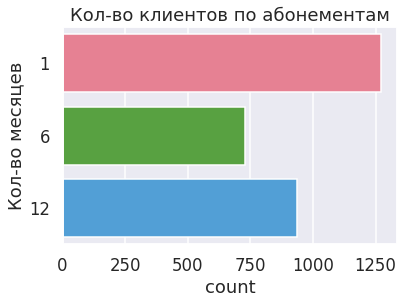

In [35]:
stay['contract_period'].value_counts().plot(kind="pie", colors=colors, autopct="%.0F%%")
plt.title('Соотношения по длительности абонементов')
plt.ylabel('Кол-во месяцев')
plt.show()
sns.countplot(y='contract_period', data=stay, palette="husl")
plt.title('Кол-во клиентов по абонементам')
plt.ylabel('Кол-во месяцев')
plt.show()

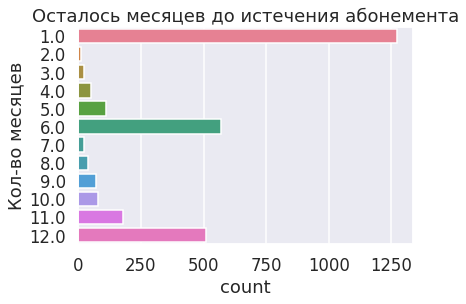

In [36]:
sns.countplot(y='month_to_end_contract', data=stay, palette="husl")
plt.title('Осталось месяцев до истечения абонемента')
plt.ylabel('Кол-во месяцев')
plt.show()

**Промежуточный вывод:** 2939 клиента осталось. Средний возраст 30 лет. В среднем посещают фитнесс-клуб 2 раза в неделю. В среднем тратят около 150 у.е. 87% проживают или работают рядом. Чуть больше половины 53% являются сотрудниками компании-партнёра клуба. 65% воспользовались пригласительным абонементом. 54% посещают групповые занятия. Из 2939 клиентов 43% имеют абонемент на 1 месяц, 32% на 12 месяцев, 25% на 6 месяцев.

### Left

In [37]:
print('Кол-во ушедших клиентов:', left.shape[0])

Кол-во ушедших клиентов: 1061


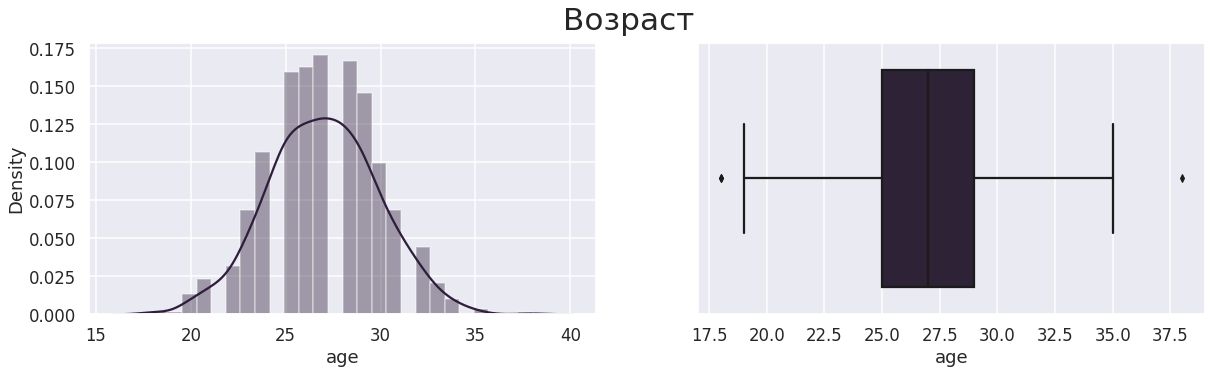

In [38]:
charts(left, 'age', 'Возраст')

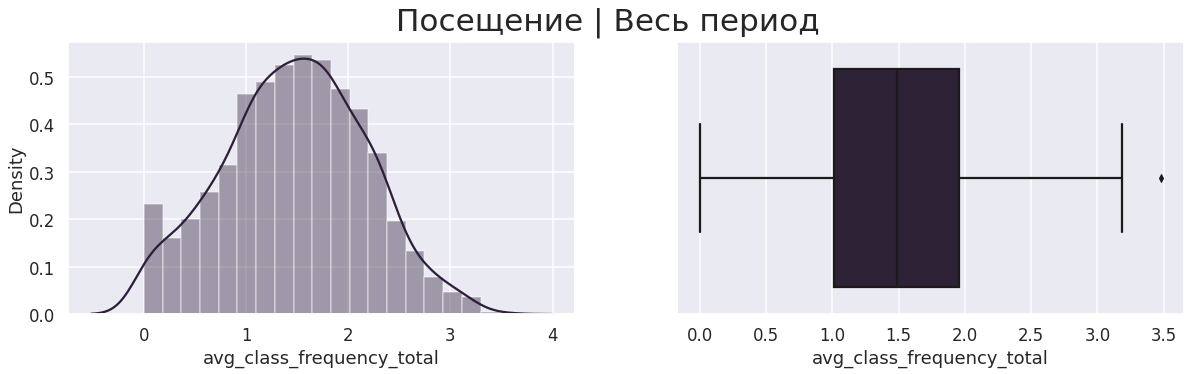

In [39]:
charts(left, 'avg_class_frequency_total', 'Посещение | Весь период')

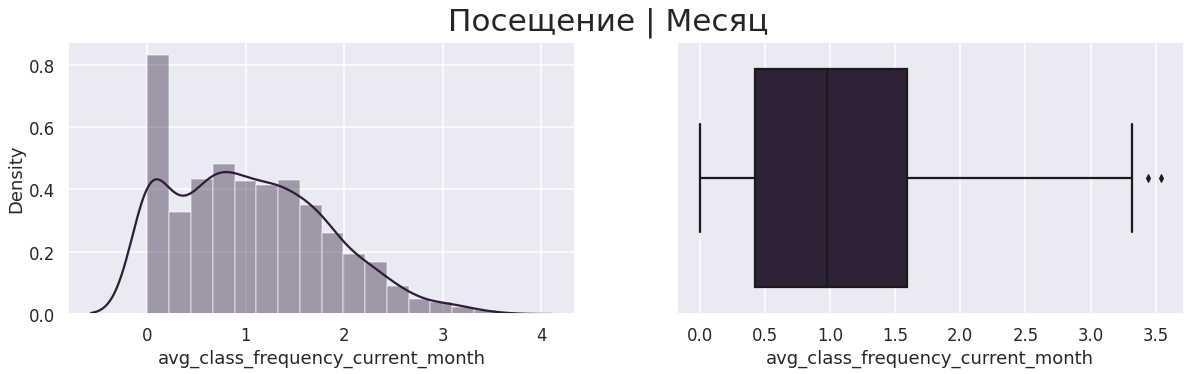

In [40]:
charts(left, 'avg_class_frequency_current_month', 'Посещение | Месяц')

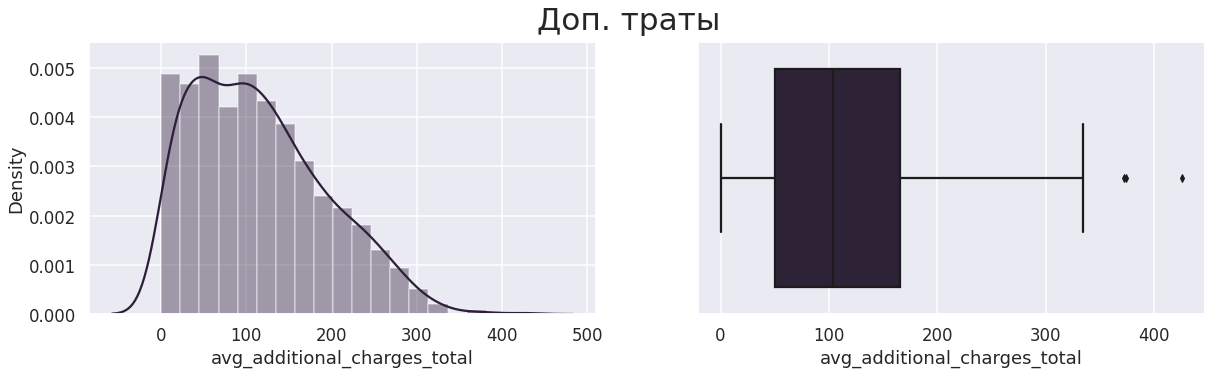

In [41]:
charts(left, 'avg_additional_charges_total', 'Доп. траты')

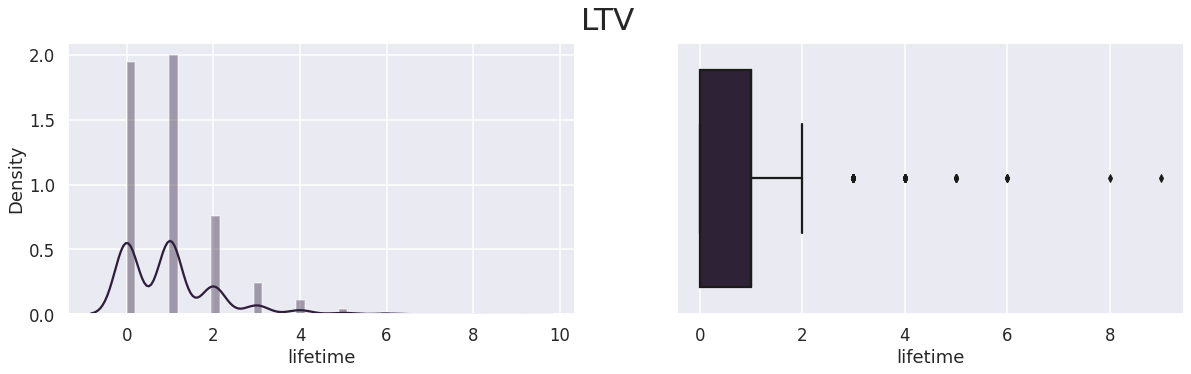

In [42]:
charts(left, 'lifetime', 'LTV')

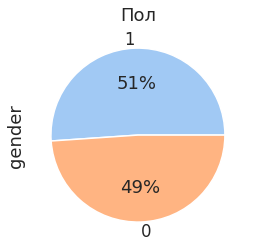

In [43]:
left['gender'].value_counts().plot(kind="pie", colors=colors, autopct="%.0f%%")
plt.title('Пол')
plt.show()

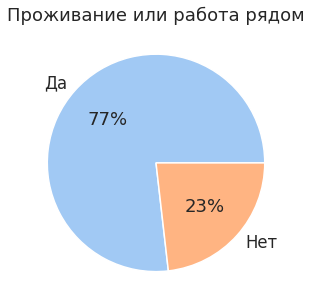

In [44]:
labels = ['Да', 'Нет']
values = left['near_location'].value_counts()

# pie chart
plt.figure(figsize=(10,5))
plt.title('Проживание или работа рядом')
plt.pie(values, labels=labels, colors=colors, autopct='%.0f%%')
plt.show()

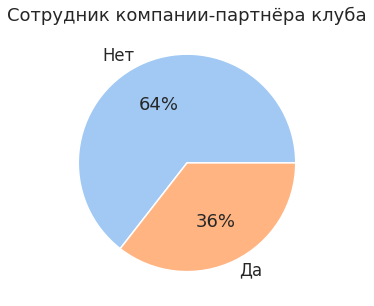

In [45]:
labels = ['Нет', 'Да']
values = left['partner'].value_counts()

# pie chart
plt.figure(figsize=(10,5))
plt.title('Сотрудник компании-партнёра клуба')
plt.pie(values, labels=labels, colors=colors, autopct='%.0f%%')
plt.show()

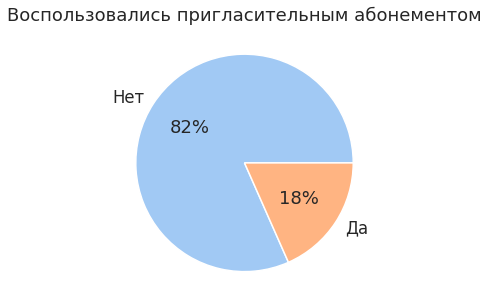

In [46]:
labels = ['Нет', 'Да']
values = left['promo_friends'].value_counts()

# pie chart
plt.figure(figsize=(10,5))
plt.title('Воспользовались пригласительным абонементом')
plt.pie(values, labels=labels, colors=colors, autopct='%.0f%%')
plt.show()

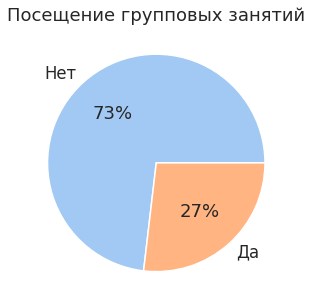

In [47]:
labels = ['Нет', 'Да']
values = left['group_visits'].value_counts()

# pie chart
plt.figure(figsize=(10,5))
plt.title('Посещение групповых занятий')
plt.pie(values, labels=labels, colors=colors, autopct='%.0f%%')
plt.show()

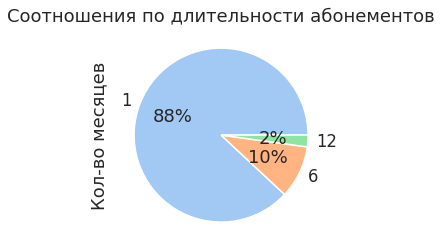

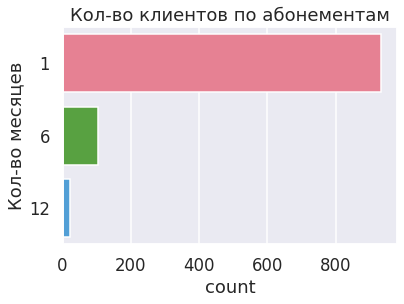

In [48]:
left['contract_period'].value_counts().plot(kind="pie", colors=colors, autopct="%.0F%%")
plt.title('Соотношения по длительности абонементов')
plt.ylabel('Кол-во месяцев')
plt.show()
sns.countplot(y='contract_period', data=left, palette="husl")
plt.title('Кол-во клиентов по абонементам')
plt.ylabel('Кол-во месяцев')
plt.show()

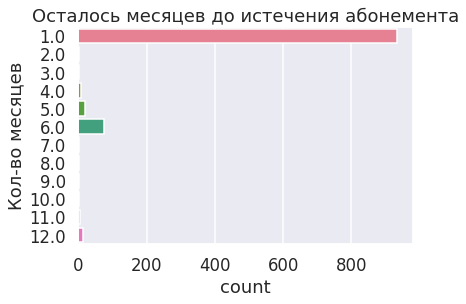

In [49]:
sns.countplot(y='month_to_end_contract', data=left, palette="husl")
plt.title('Осталось месяцев до истечения абонемента')
plt.ylabel('Кол-во месяцев')
plt.show()

**Промежуточный вывод:** 1061 клиент ушел. Средний возраст 27 лет. В среднем посещают фитнесс-клуб 1 раза в неделю. В среднем тратят около 110 у.е. 77% проживают или работают рядом, что 10% меньше чем у оставшихся. Интересно, что 64% ушедших не являются сотрудниками компании-парнёра клуба. Всего 18% воспользовались пригласительным абонементом. Только 27% из них посещали групповые занятия. Из 1061 клиентов 88% имеют абонемент на 1 месяц, 2% на 12 месяцев, 10% на 6 месяцев.

###  Корреляция

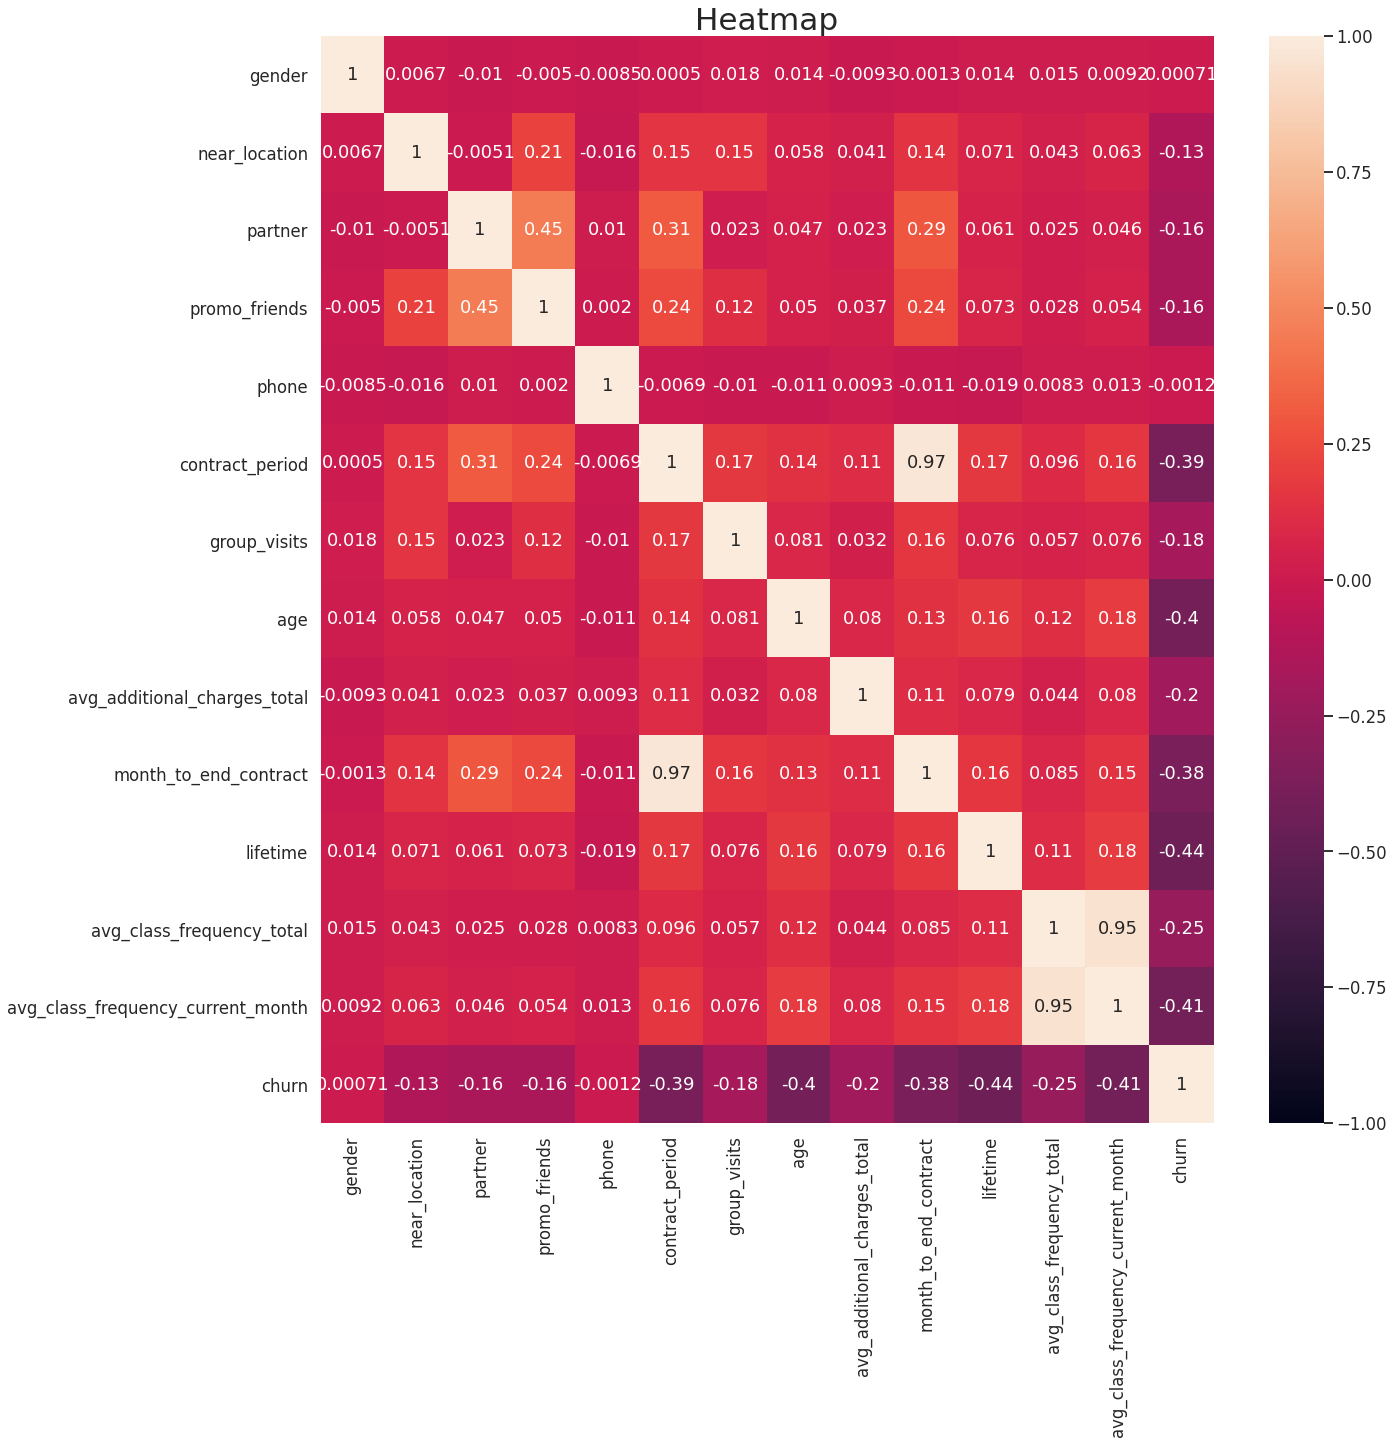

In [50]:
plt.figure(figsize=(20,20))
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True)
plt.title('Heatmap', fontsize='xx-large')
plt.show()

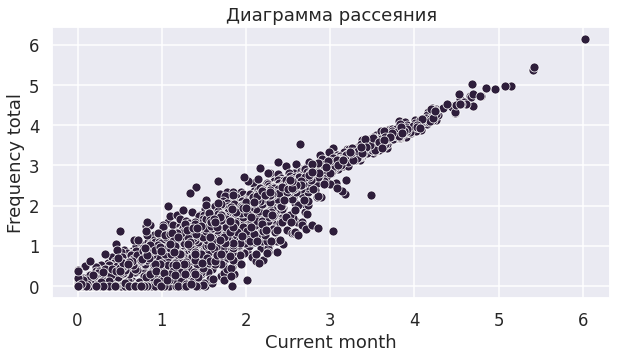

In [51]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=data, x='avg_class_frequency_total', y='avg_class_frequency_current_month')
plt.title('Диаграмма рассеяния')
plt.xlabel('Current month')
plt.ylabel('Frequency total')
plt.show()

**Промежуточные выводы:** Видим, сильную связь между столбцами «avg_class_frequency_total» и «avg_class_frequency_current_month» — 0.95. (изобразили на графике). Также, очень высокая корреляция — 0.97 в данных о длительности текущего действия абонемента и сроком до окончания текущего действия абонемента. Слабая корреляция — 0.45 — наблюдается между признаками «сотрудник компании-партнёра клуба» и акции «приведи друга». Избавляемся от мультиколлинеарности, удаляем столбцы avg_class_frequency_total и contract_period.

## Подготовка данных к обучению

In [52]:
del data['avg_class_frequency_total'], data['contract_period']

In [53]:
x = data.drop('churn', axis=1)
y = data['churn']

In [54]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

print('Train shape:', x_train.shape)
print('Test shape:', x_test.shape)

Train shape: (3200, 11)
Test shape: (800, 11)


In [55]:
scaler = StandardScaler()
x_train_st = scaler.fit_transform(x_train)
x_test_st = scaler.transform(x_test)

**Промежуточные выводы:** Определили значения признаков `x` и целевую переменную `y`. Разделили данные на обучающую и тестовую выборки в пропорции 80:20. Стандартизировали данные. 

## Обучение моделей

In [56]:
model_1 = LogisticRegression(random_state=0)
model_2 = RandomForestClassifier(random_state=0)

param_LR = {'C': [0.01, 0.1, 1, 10, 100], 'solver' : ['liblinear', 'lbfgs']}
param_RF = {'n_estimators':[5,100],
             'max_depth':[1,20], 'min_samples_split': [2, 3]}

LR = GridSearchCV(model_1 ,param_grid = param_LR, cv=5)
RF = GridSearchCV(model_2,param_grid = param_RF, cv=5)

### Logistic regression

In [57]:
%%time
#Logistic regression
start_1 = time.time()
LR.fit(x_train_st, y_train)
end_1 = time.time()
fit_LR = end_1 - start_1

start_2 = time.time()
prediction_LR = LR.predict(x_test_st)
end_2 = time.time()
pred_LR = end_2 - start_2

pre_proba_LR = LR.predict_proba(x_test_st)[:,1]

roc_auc_LR_proba = roc_auc_score(y_test, pre_proba_LR)
accuracy_LR = accuracy_score(y_test, prediction_LR)
precision_LR = precision_score(y_test, prediction_LR)
recall_LR = recall_score(y_test, prediction_LR)


print('\n========================================================')
print('Logistic регрессия')
print('========================================================')
print('ROC-AUC:', round(roc_auc_LR_proba, 4) )
print('Accuracy:', round(accuracy_LR, 4))
print('Precision:', round(precision_LR, 4))
print('Recall:', round(recall_LR, 4))
print('Время обучения:', round(fit_LR,4), 'vs', 'Время предсказания', round(pred_LR,4))
print()
print('Наилучшие гиперпараметры:',LR.best_params_)
print()


Logistic регрессия
ROC-AUC: 0.9632
Accuracy: 0.9088
Precision: 0.8109
Recall: 0.8232
Время обучения: 2.8678 vs Время предсказания 0.0002

Наилучшие гиперпараметры: {'C': 0.1, 'solver': 'lbfgs'}

CPU times: user 1.23 s, sys: 1.72 s, total: 2.95 s
Wall time: 2.96 s


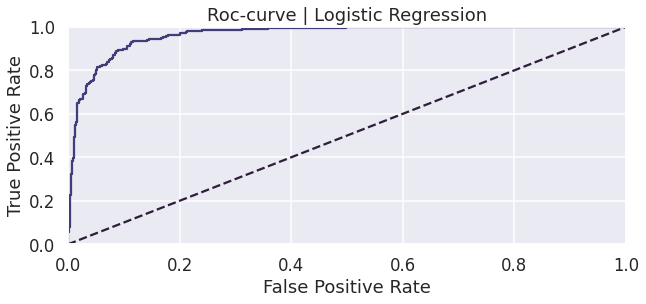

AUC-ROC: 0.9632


In [58]:
fpr, tpr, thresholds = roc_curve(y_test, pre_proba_LR)

plt.figure(figsize=(10,4))
plt.plot([0,1],[0,1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc-curve | Logistic Regression')
plt.show()

print('AUC-ROC:', round(roc_auc_LR_proba, 4))

### Random Forest

In [59]:
%%time
#Random Forest
start_1 = time.time()
RF.fit(x_train_st, y_train)
end_1 = time.time()
fit_RF = end_1 - start_1

start_2 = time.time()
prediction_RF = RF.predict(x_test_st)
end_2 = time.time()
pred_RF = end_2 - start_2

pre_proba_RF = RF.predict_proba(x_test_st)[:,1]

roc_auc_RF_proba = roc_auc_score(y_test, pre_proba_RF)
accuracy_RF = accuracy_score(y_test, prediction_RF)
precision_RF = precision_score(y_test, prediction_RF)
recall_RF = recall_score(y_test, prediction_RF)


print('\n========================================================')
print('Random Forest')
print('========================================================')
print('ROC-AUC:', round(roc_auc_RF_proba, 4) )
print('Accuracy:', round(accuracy_RF, 4))
print('Precision:', round(precision_RF, 4))
print('Recall:', round(recall_RF, 4))
print('Время обучения:', round(fit_RF,4), 'vs', 'Время предсказания', round(pred_RF,4))
print()
print('Наилучшие гиперпараметры:',RF.best_params_)
print()


Random Forest
ROC-AUC: 0.9491
Accuracy: 0.895
Precision: 0.8065
Recall: 0.7576
Время обучения: 4.3469 vs Время предсказания 0.0176

Наилучшие гиперпараметры: {'max_depth': 20, 'min_samples_split': 3, 'n_estimators': 100}

CPU times: user 4.37 s, sys: 0 ns, total: 4.37 s
Wall time: 4.39 s


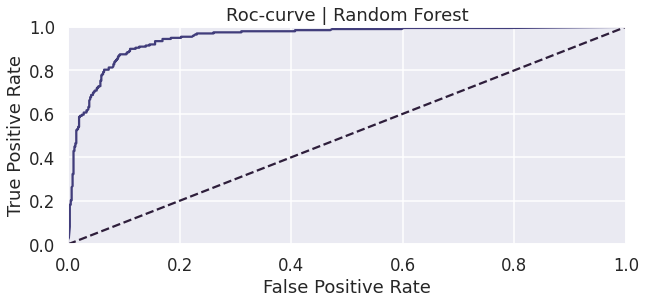

AUC-ROC: 0.9491


In [60]:
fpr, tpr, thresholds = roc_curve(y_test, pre_proba_RF)

plt.figure(figsize=(10,4))
plt.plot([0,1],[0,1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc-curve | Random Forest')
plt.show()

print('AUC-ROC:', round(roc_auc_RF_proba, 4))

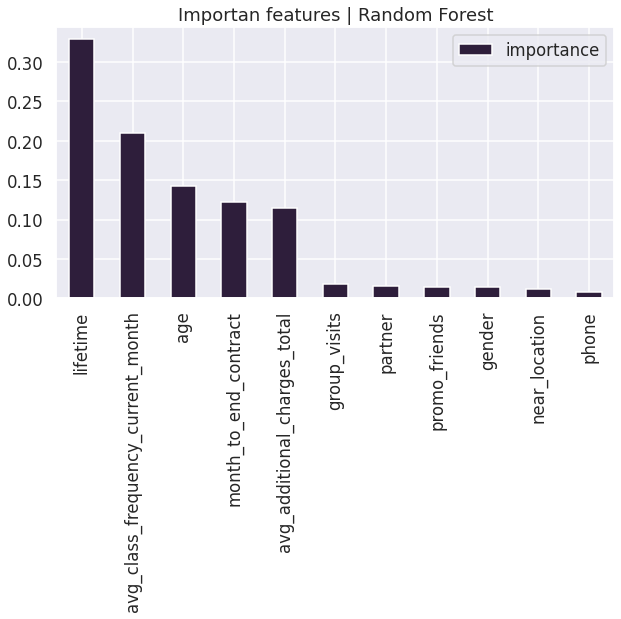

In [61]:
imp = pd.DataFrame(RF.best_estimator_.feature_importances_, index = x_test.columns, columns=['importance'])
imp = imp.sort_values(by='importance', ascending=False).plot(kind='bar', figsize=(10, 5), title='Importan features | Random Forest')

### Анализ моделей

По итогам исследования удалось установить, что важным признаками для предсказания оттока являются Lifetime, посещение за последний месяц и возраст.

В ходе исследования обучили 2 модели и для каждой попробовали различные гипепараметры.

Оптимальным выбором будет алгоритм Логистическая регрессия. Данный алгоритм показал наилучшую скорость обучения и предсказания, а все метрики оказались лучше, чем у алгоритма Случайного Леса.

## Кластеризация клиентов

In [62]:
x_sc = scaler.fit_transform(x)
x_sc[:2]

array([[ 0.97970588,  0.42788074,  1.02686062,  1.49716101, -3.05985201,
         1.19403206, -0.0565538 , -1.37753121,  0.16160501, -0.19332863,
        -1.67847198],
       [-1.0207145 ,  0.42788074, -0.973842  , -0.66793083,  0.32681319,
         1.19403206,  0.55732732, -0.35021325,  1.83194105,  0.87368001,
         0.1360137 ]])

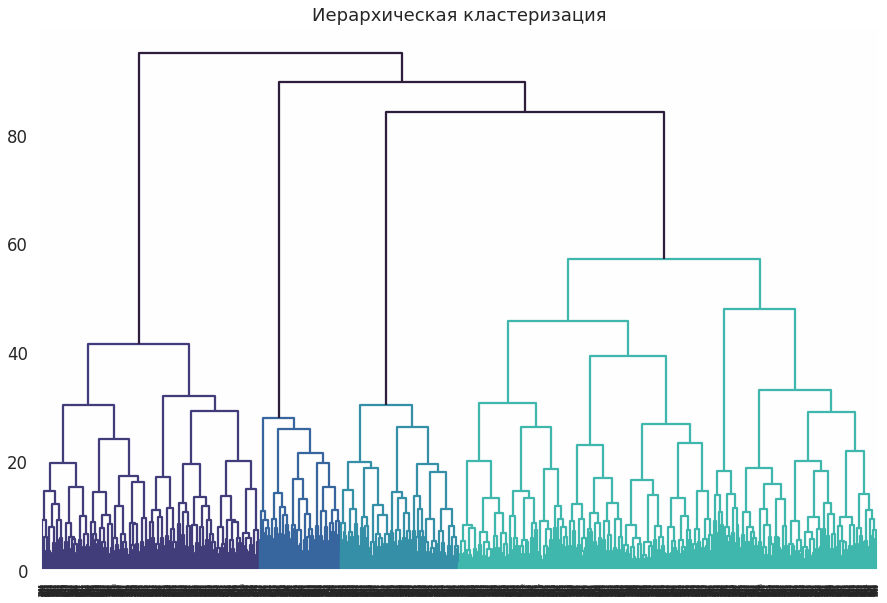

In [63]:
linked = linkage(x_sc, method='ward')

plt.figure(figsize=(15,10))
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')
plt.show() 


In [64]:
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(x_sc)

data['cluster'] = labels
data.head()

,gender,near_location,partner,promo_friends,phone,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_current_month,churn,cluster
0,1,1,1,1,0,1,29,14.227470,5.0,3,0.000000,0,0
1,0,1,0,0,1,1,31,113.202938,12.0,7,1.910244,0,4
2,0,1,1,0,1,0,28,129.448479,1.0,2,1.736502,0,2
3,0,1,1,1,1,1,33,62.669863,12.0,2,3.357215,0,0
4,1,1,1,1,1,0,26,198.362265,1.0,3,1.120078,0,0


In [65]:
print('Метрика силуэта', round(silhouette_score(x_sc, labels),2))

Метрика силуэта 0.12


Для кластера=2, Метрика силуэта = 0.13772040615200434
Для кластера=3, Метрика силуэта = 0.15254844909842707
Для кластера=4, Метрика силуэта = 0.16452342406437412
Для кластера=5, Метрика силуэта = 0.11546085235095088
Для кластера=6, Метрика силуэта = 0.12758121008372342
Для кластера=7, Метрика силуэта = 0.12616439796549173


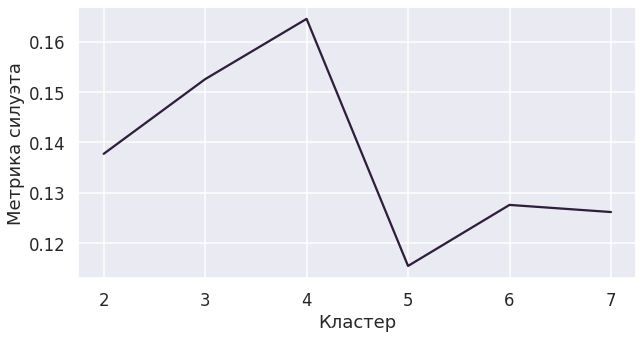

Оптимальное кол-во кластеров: 4


In [66]:
k_clusters = []
silhouette_coeff = []

for n_cluster in range(2,8):
    km = KMeans(n_clusters = n_cluster, random_state=0)
    label = km.fit_predict(x_sc)
    sil_coeff = silhouette_score(x_sc, label)
    print("Для кластера={}, Метрика силуэта = {}".format(n_cluster, sil_coeff))
    silhouette_coeff.append(sil_coeff)
    k_clusters.append(n_cluster)

plt.figure(figsize=(10,5))
plt.plot(k_clusters, silhouette_coeff)
plt.ylabel('Метрика силуэта'), plt.xlabel('Кластер')
plt.show()

sil_best = max(silhouette_coeff)
k_best_index = silhouette_coeff.index(sil_best)
k_best = k_clusters[k_best_index]
print("Оптимальное кол-во кластеров:", k_best)

In [67]:
data.groupby('cluster').mean().T

cluster,0,1,2,3,4
gender,0.492000,0.495352,0.511194,0.502455,0.550481
near_location,0.994000,0.998672,1.000000,0.000000,0.998798
partner,0.953000,0.378486,0.226368,0.489362,0.274038
promo_friends,1.000000,0.046481,0.114428,0.072013,0.075721
phone,0.906000,0.903054,0.899254,0.913257,0.897837
group_visits,0.528000,0.000000,0.182836,0.232406,1.000000
age,29.633000,30.342629,26.807214,28.700491,30.248798
avg_additional_charges_total,154.086252,174.392898,111.073289,137.375245,155.206260
month_to_end_contract,6.730000,4.698539,1.715174,2.826514,4.707933
lifetime,4.287000,5.166003,1.420398,3.027823,4.483173


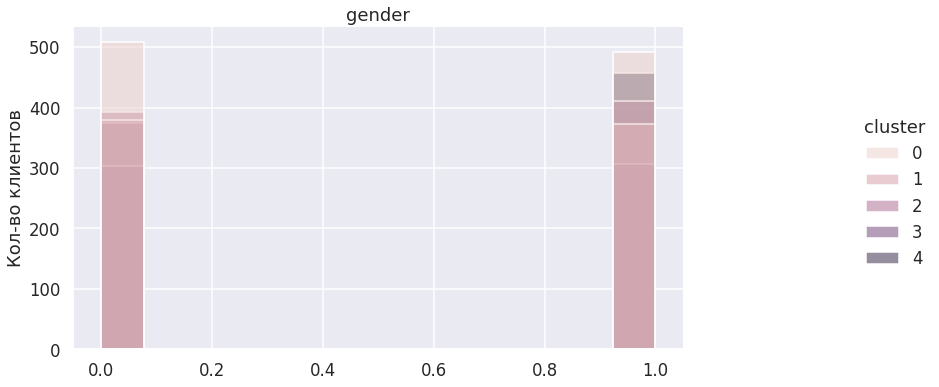

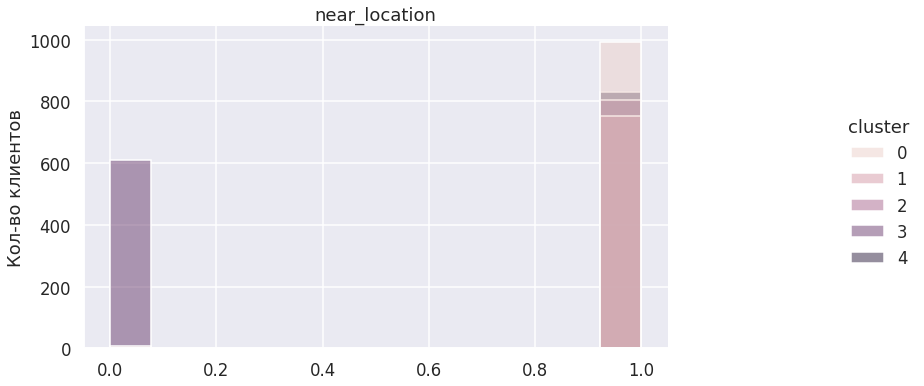

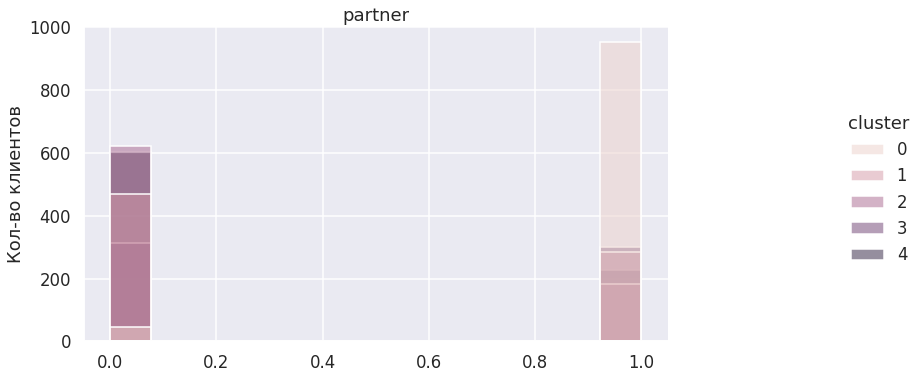

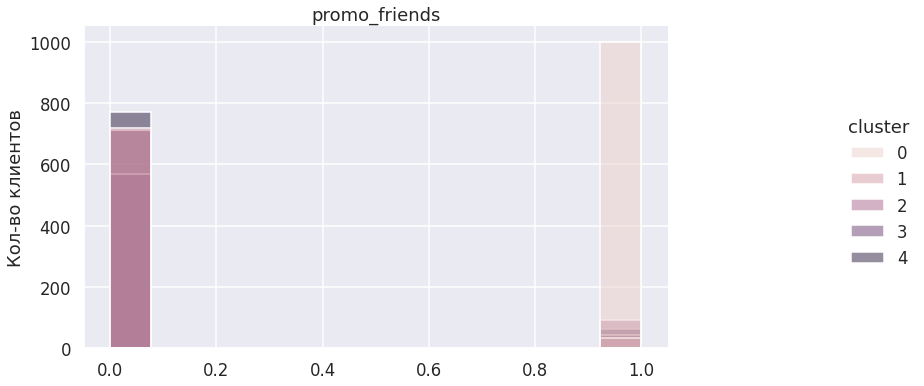

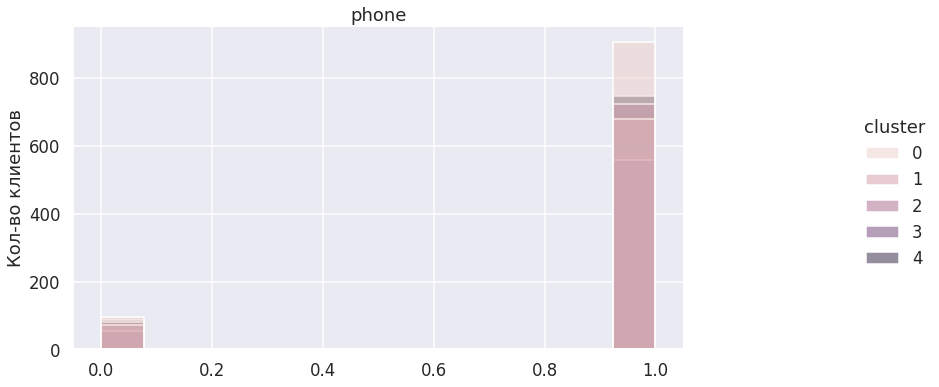

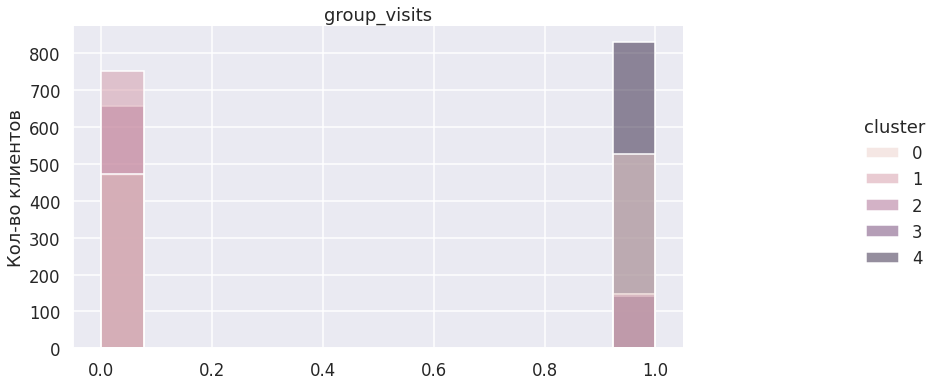

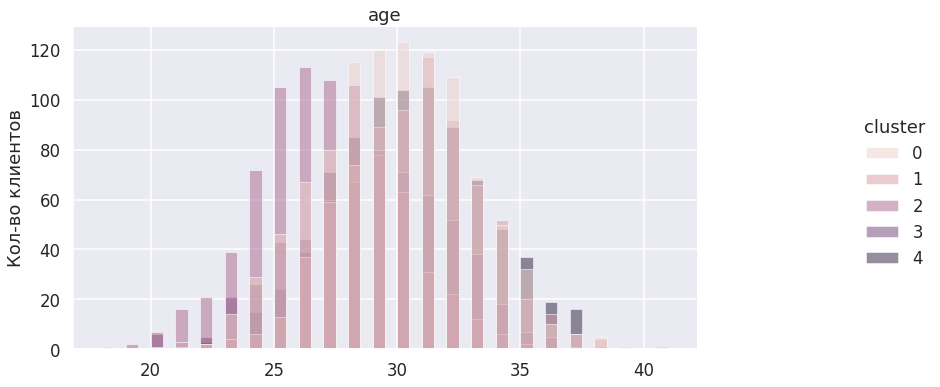

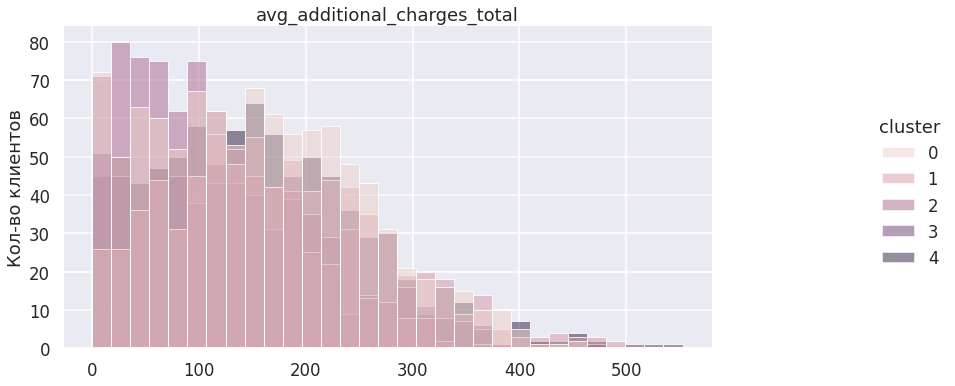

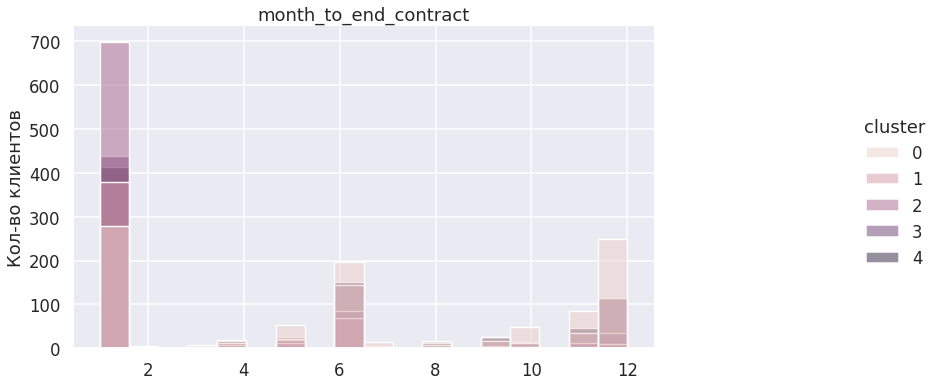

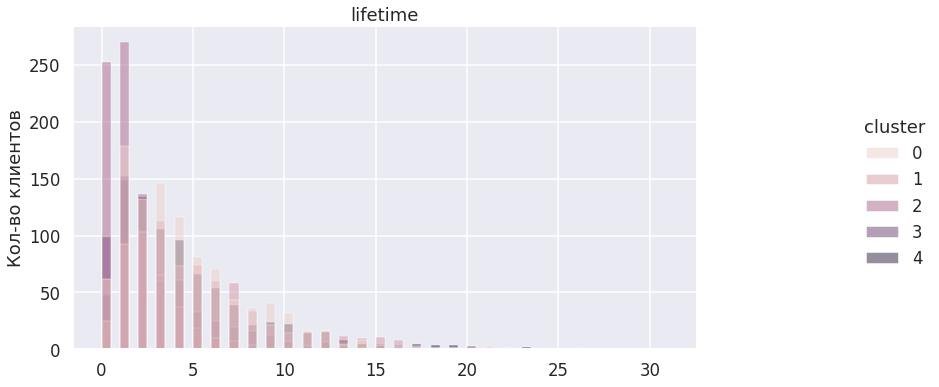

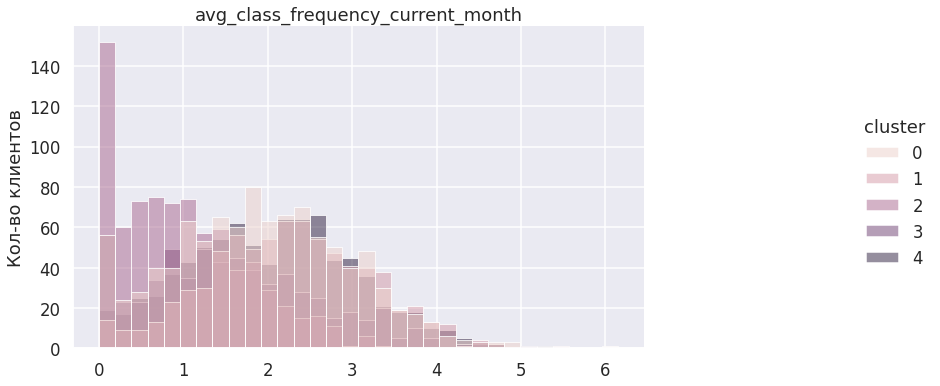

In [68]:
for i in x:
    dis = sns.displot(data, x=data[i], hue='cluster', kind='hist' )
    plt.title(i)
    plt.ylabel('Кол-во клиентов')
    plt.xlabel('')
    dis.fig.set_figwidth(15)
    dis.fig.set_figheight(6)
    dis.fig.patch.set_linewidth(5)

**Промежуточные выводы:**
И так, у нас получилось, в принципе, реалистичная картина. Рассмотрим детально 5 кластеров. 

0 - кластер:
Отток - 10%.
Средний возраст 29 лет.
Доп. траты: 154 у.е.
Средняя длинна контракта 6-7 месяцев.
Абсолютное большинство работают рядом, так как 95% указывает на то, что клиент является сотрудником компании-партнера. А также воспользовалась акцией «приведи друга» — 100%, видимо, коллеги рекомендуют друг другу. Половина (52%) посещают групповые занятия. Ходят примерно 2 раза в неделю.

1 - кластер:
Отток — 5%.
Средний возраст 30 лет.
Доп. траты: 174 у.е.
Средняя длинна контракта 4 месяца.
Абсолютное большинство живет рядом, так как тут только 37% указывает на то, что клиент является сотрудником компании-партнера. А также воспользовалась акцией «приведи друга» всего 4% и вообще не посещают групповые занятия. Ходят, примерно, чаще 2-х раз в неделю.

2 — кластер:
Отток — 74%.
Средний возраст 26 лет.
Доп. траты: 111 у.е.
Средняя длинна контракта 1-2 месяца.
Абсолютное большинство живёт рядом, так как тут только 22% указывает на то, что клиент является сотрудником компании-партнера. А также воспользовалась акцией «приведи друга» всего 11%, а посещают групповые занятия всего 18%. Ходят один раз в неделю, если вообще ходят.

3 — кластер:
Отток — 40%.
Средний возраст 28 лет.
Доп. траты: 137 у.е.
Средняя длинна контракта 3 месяца.
Не живут рядом и не работают. При это, примерно, половина являются сотрудниками компании-партнера (48%), скорей всего работают в филиалах не по близости. Воспользовалась акцией «приведи друга» всего 7%, а посещают групповые занятия всего 23%. Ходят от 1 до 2 раз в неделю.

4 — кластер:
Отток — 9%.
Средний возраст 30 лет.
Доп. траты: 155 у.е.
Средняя длинна контракта 4 месяца.
Lifetime — 4.7
Большинство живет рядом и только 27% являются сотрудниками компании-партнера. Воспользовалась акцией «приведи друга» всего 7%. Все посещают групповые занятия. Ходят 2 раз в неделю.

Стоит отметить, что 5-й кластер (4 — кластер) не сильно, но выделяется на фоне других кластеров. Да и по графику метрики силуэта хорошо видно, что 5 кластер можно смело отбросить и оставить только первые четыре кластера.

## Вывод

Мы получили данные о 4 тыс. клиентах и на момент анализа имели следующую портрет клиента:

2939 клиента осталось. Средний возраст 30 лет. В среднем посещают фитнесс-клуб 2 раза в неделю. В среднем тратят около 150 у.е. 87% проживают или работают рядом. Чуть больше половины 53% являются сотрудниками компании-партнёра клуба. 65% воспользовались пригласительным абонементом. 54% посещают групповые занятия. Из 2939 клиентов 43% имеют абонемент на 1 месяц, 32% на 12 месяцев, 25% на 6 месяцев.

1061 клиент ушел. Средний возраст 27 лет. В среднем посещают фитнесс-клуб 1 раза в неделю. В среднем тратят около 110 у.е. 77% проживают или работают рядом, что 10% меньше чем у оставшихся. Интересно, что 64% ушедших не являются сотрудниками компании-парнёра клуба. Всего 18% воспользовались пригласительным абонементом. Только 27% из них посещали групповые занятия. Из 1061 клиентов 88% имеют абонемент на 1 месяц, 2% на 12 месяцев, 10% на 6 месяцев.


**Машинное обучение**

В рамках проекта мы обучили два алгоритма и выявили, что для решения проблемы прогнозирования вероятности оттока лучшего всего подойдет алгоритм Логистическая регрессия. Данный алгоритм показал наилучшую скорость обучения и предсказания, а все метрики оказались лучше, чем у алгоритма Случайного Леса.

- ROC-AUC: 0.9632
- Accuracy: 0.9088
- Precision: 0.8109
- Recall: 0.8232
- Время обучения: 4.1716 vs Время предсказания 0.0003

Наилучшие гиперпараметры: {'C': 0.1, 'solver': ‘lbfgs'}

Также, удалось установить, что важным признаками для предсказания оттока являются Lifetime, посещение за последний месяц и возраст.


**Кластеризация**

Для составления более точной картины, мы провели кластеризацию из которой можно выделять 4 явных группы клиентов:

0 - кластер: Отток - 10%. Средний возраст 29 лет. Доп. траты: 154 у.е. Средняя длинна контракта 6-7 месяцев. Абсолютное большинство работают рядом, так как 95% указывает на то, что клиент является сотрудником компании-партнера. А также воспользовалась акцией «приведи друга» — 100%, видимо, коллеги рекомендуют друг другу. Половина (52%) посещают групповые занятия. Ходят примерно 2 раза в неделю.

1 - кластер: Отток — 5%. Средний возраст 30 лет. Доп. траты: 174 у.е. Средняя длинна контракта 4 месяца. Абсолютное большинство живет рядом, так как тут только 37% указывает на то, что клиент является сотрудником компании-партнера. А также воспользовалась акцией «приведи друга» всего 4% и вообще не посещают групповые занятия. Ходят, примерно, чаще 2-х раз в неделю.


2 — кластер: Отток — 74%. Средний возраст 26 лет. Доп. траты: 111 у.е. Средняя длинна контракта 1-2 месяца. Абсолютное большинство живёт рядом, так как тут только 22% указывает на то, что клиент является сотрудником компании-партнера. А также воспользовалась акцией «приведи друга» всего 11%, а посещают групповые занятия всего 18%. Ходят один раз в неделю, если вообще ходят.

3 — кластер: Отток — 40%. Средний возраст 28 лет. Доп. траты: 137 у.е. Средняя длинна контракта 3 месяца. Не живут рядом и не работают. При это, примерно, половина являются сотрудниками компании-партнера (48%), скорей всего работают в филиалах не по близости. Воспользовалась акцией «приведи друга» всего 7%, а посещают групповые занятия всего 23%. Ходят от 1 до 2 раз в неделю.


**Рекомендации:**

Целевая аудитория : мужчина или женщина, который(ая) живет или работает близко от зала,а также старше 28 лет.

- Исходя из портретов и характеристик полученных кластеризацией можно прогнозировать ту или иную вероятность оттока клиента с момента переговоров об покупке абонемента. Поэтому следует информировать отдел продаж об особенностях клиентов, которые хотят брать абонемент на короткий срок, и после сбора данных: о расстоянии до клуба, возрасте и планах о посещении групповых занятий относить клиентов в одну из 4 групп кластера.
- Продолжать предлагать партнерские программы и промо-акции для новых клиентов.
- Предлагать более выгодные условия на абонементы за 6 и 12 месяцев.
- Предлагать участвовать в групповых занятиях.
- Повысить привлекательность групповых занятий среди относительно молодых клиентов.
- Мотивировать чаще ходить на тренировки